# Transforming New Data With UMAP

UMAP is useful for generating visualisations, but if you want to make use of UMAP more generally for machine learning tasks it is important to be be able to train a model and then later pass new data to the model and have it transform that data into the learned space. For example if we use UMAP to learn a latent space and then train a classifier on data transformed into the latent space then the classifier is only useful for prediction if we can transform data for which we want a prediction into the latent space the classifier uses.

In [2]:
import keras
from sklearn.model_selection import train_test_split

from umap import UMAP, ParametricUMAP

import matplotlib.pyplot as plt

import numpy as np


2024-10-12 16:36:09.292491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 16:36:09.327100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 16:36:09.338231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 16:36:09.364220: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 16:36:13.617408: W tensorflow/comp

We'll start by loading in the MNIST handwritten digit dataset, and splitting it into 2 equal parts with sklearn's ``train_test_split`` function. This will give us two partitions to work with, one to train our original embedding and another to test it. In order to simulate new behaviour appearing in our data we remove one of the MNIST categories (digits), ``N``, from the ``x1`` partition.

In [3]:
n_samples = -1 #-1 to use all samples.

(X, y), (_, _) = keras.datasets.mnist.load_data()
x1, x2, y1, y2 = train_test_split(X[:n_samples], y[:n_samples], test_size=0.5, random_state=42)

# Reshape to 1D vectors
x1 = x1.reshape((x1.shape[0], 28*28))
x2 = x2.reshape((x2.shape[0], 28*28))

# Remove one category from the train dataset.
# In the case of MNIST digits, this will be the digit we are removing.
N = 2

x1 = x1[y1 != N]
y1 = y1[y1 != N]

print(x1.shape, x2.shape)

(26995, 784) (30000, 784)


Firstly, we'll train a ``UMAP`` embedder on ``x1``. This is straightforward.

In [4]:
embedder = UMAP()

emb_x1 = embedder.fit_transform(x1)

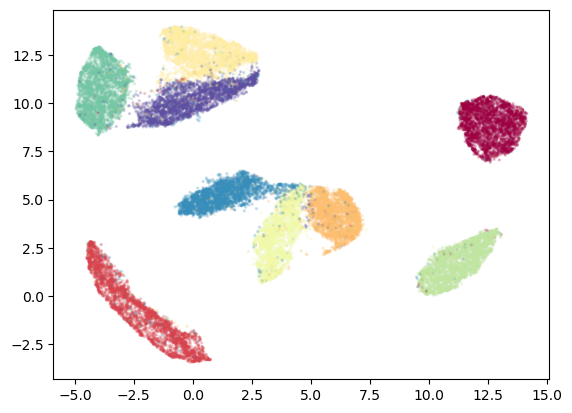

In [5]:
plt.scatter(emb_x1[:,0], emb_x1[:,1], c=y1, cmap='Spectral', s=2, alpha=0.2)

UMAP is built to be compatible with ``scikit-learn``, so passing new data through is as simple as using the ``transform`` method and passing through the new data to transform. We'll pass through ``x2``, which contains unseen examples of the original classes, and also samples from our holdout class, ``N``.

To make samples from ``N`` Stand out more, we'll over-plot them in black.

In [6]:
emb_x2 = embedder.transform(x2)

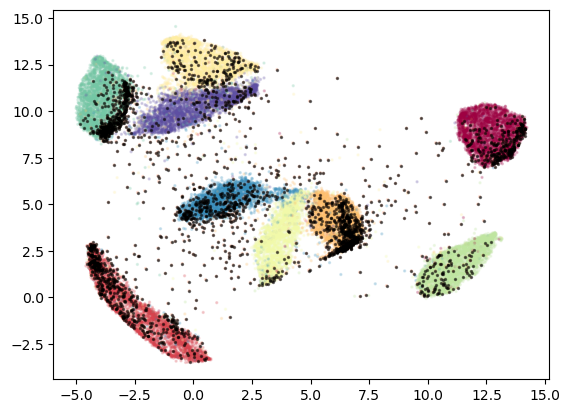

In [7]:
plt.scatter(emb_x2[:,0], emb_x2[:,1], c=y2, cmap='Spectral', s=2, alpha=0.2)
plt.scatter(emb_x2[y2==N][:,0], emb_x2[y2==N][:,1], c='k', s=2, alpha=0.5)

While our ``UMAP`` embedder has correctly handled the classes present in ``x1`` it has treated examples from class ``N`` poorly. Many of these points are concentrated on top of existing classes, with some spread out between them. This inability to generalize may or may not be an issue, depending on your use case. Parametric UMAP can provide a solution to this through updating the parametric model weights.

We will start adressing this by training a ``ParametricUMAP`` embedding model.

In [8]:
p_embedder = ParametricUMAP()

p_emb_x1 = p_embedder.fit_transform(x1)

Epoch 1/10


/home/jacob.golding1/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


3507/3507 ━━━━━━━━━━━━━━━━━━━━ 154s 38ms/step - loss: 0.2557
Epoch 2/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 127s 36ms/step - loss: 0.2014
Epoch 3/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 126s 36ms/step - loss: 0.1953
Epoch 4/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 125s 36ms/step - loss: 0.1926
Epoch 5/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 125s 36ms/step - loss: 0.1908
Epoch 6/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 125s 36ms/step - loss: 0.1893
Epoch 7/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 124s 35ms/step - loss: 0.1880
Epoch 8/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 124s 35ms/step - loss: 0.1868
Epoch 9/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 126s 36ms/step - loss: 0.1861
Epoch 10/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 124s 35ms/step - loss: 0.1855


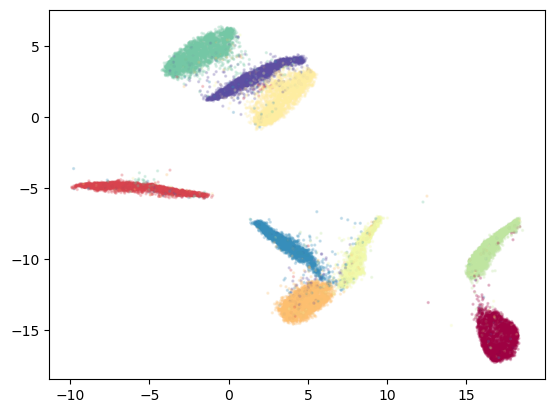

In [9]:
plt.scatter(p_emb_x1[:,0], p_emb_x1[:,1], c=y1, cmap='Spectral', s=2, alpha=0.2)

This gives us our normal UMAP result for MNIST, but with only 9 categories.

Similarly to the ``UMAP`` Model, adding new data here is straightforward, we can use the ``transform`` method. Like last time, we will overplot our samples from class ``N`` in black.

In [10]:
p_emb_x2 = p_embedder.transform(x2)

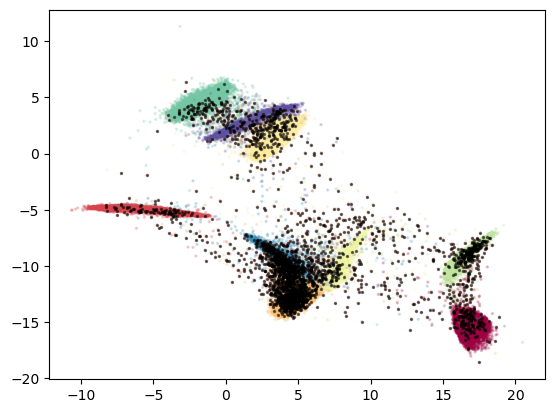

In [11]:
plt.scatter(p_emb_x2[:,0], p_emb_x2[:,1], c=y2, cmap='Spectral', s=2, alpha=0.2)
plt.scatter(p_emb_x2[y2==N][:,0], p_emb_x2[y2==N][:,1], c='k', s=2, alpha=0.5)

As with our ``UMAP`` model, the original classes present in ``x1`` have been treated reasonably, but our holdout class ``N`` has been embedded on top of existing classes.

In order to update our embedding to include the new class, we'll fine-tune our existing ``ParametricUMAP`` model. Doing this without any other changes will start from where we left off, but our embedding space's structure may drift and change. This is because our UMAP loss function is invariant to scaling, translation, and rotation, as it is only concerned with the relative positions and distances between points. 

In order to keep our embedding space more consistent, we'll use the landmarks option for ``ParametricUMAP``. We'll retrain the model on the ``x2`` partition, along with some points chosen as landmarks from ``x1``. We'll choose 1% of the samples in ``x1`` to be included, along with their current position in the embedding space.

The default ``landmark_loss_fn`` is the euclidean distance between the point's original position and it's current one. The only change we'll make is to set ``landmark_loss_weight=0.01``. We can tune this number by looking at the training history, which we'll take a look at later on.

In [12]:
# Select landmarks indexes from x1.
#
landmark_idx = list(np.random.choice(range(x1.shape[0]), int(x1.shape[0]/100), replace=False))

# Add the landmark points to x2 for training.
#
x2_lmk = np.concatenate((x2, x1[landmark_idx]))
y2_lmk = np.concatenate((y2, y1[landmark_idx]))

# Make our landmarks vector, which is nan where we have no landmark information.
#
landmarks = np.stack(
    [np.array([np.nan, np.nan])]*x2.shape[0] + list(
        p_embedder.transform(
            x1[landmark_idx]
        )
    )
)

# Set landmark loss weight and continue training our Parametric UMAP model.
#
p_embedder.landmark_loss_weight = 0.01
p_embedder.fit(x2_lmk, landmark_positions=landmarks)

p_emb2_x2 = p_embedder.transform(x2)

# How does x1 look when embedded in the space retrained on x2 and landmarks?
#
p_emb2_x1 = p_embedder.transform(x1)

Epoch 1/10
3923/3923 ━━━━━━━━━━━━━━━━━━━━ 184s 40ms/step - loss: 0.2113
Epoch 2/10
3923/3923 ━━━━━━━━━━━━━━━━━━━━ 138s 35ms/step - loss: 0.1956
Epoch 3/10
3923/3923 ━━━━━━━━━━━━━━━━━━━━ 137s 35ms/step - loss: 0.1938
Epoch 4/10
3923/3923 ━━━━━━━━━━━━━━━━━━━━ 137s 35ms/step - loss: 0.1923
Epoch 5/10
3923/3923 ━━━━━━━━━━━━━━━━━━━━ 138s 35ms/step - loss: 0.1914
Epoch 6/10
3923/3923 ━━━━━━━━━━━━━━━━━━━━ 136s 35ms/step - loss: 0.1907
Epoch 7/10
3923/3923 ━━━━━━━━━━━━━━━━━━━━ 137s 35ms/step - loss: 0.1904
Epoch 8/10
3923/3923 ━━━━━━━━━━━━━━━━━━━━ 138s 35ms/step - loss: 0.1901
Epoch 9/10
3923/3923 ━━━━━━━━━━━━━━━━━━━━ 138s 35ms/step - loss: 0.1900
Epoch 10/10
3923/3923 ━━━━━━━━━━━━━━━━━━━━ 139s 35ms/step - loss: 0.1902


We now plot the different embeddings to see how well our additional training has worked. We can see here the value of this approach, our embedding space is consistent with the initial embedding, but our cluster of ``N`` samples is now neatly clustered in an appropriate part of the space, as opposed to being distributed unhelpfully on top of existing clusters.

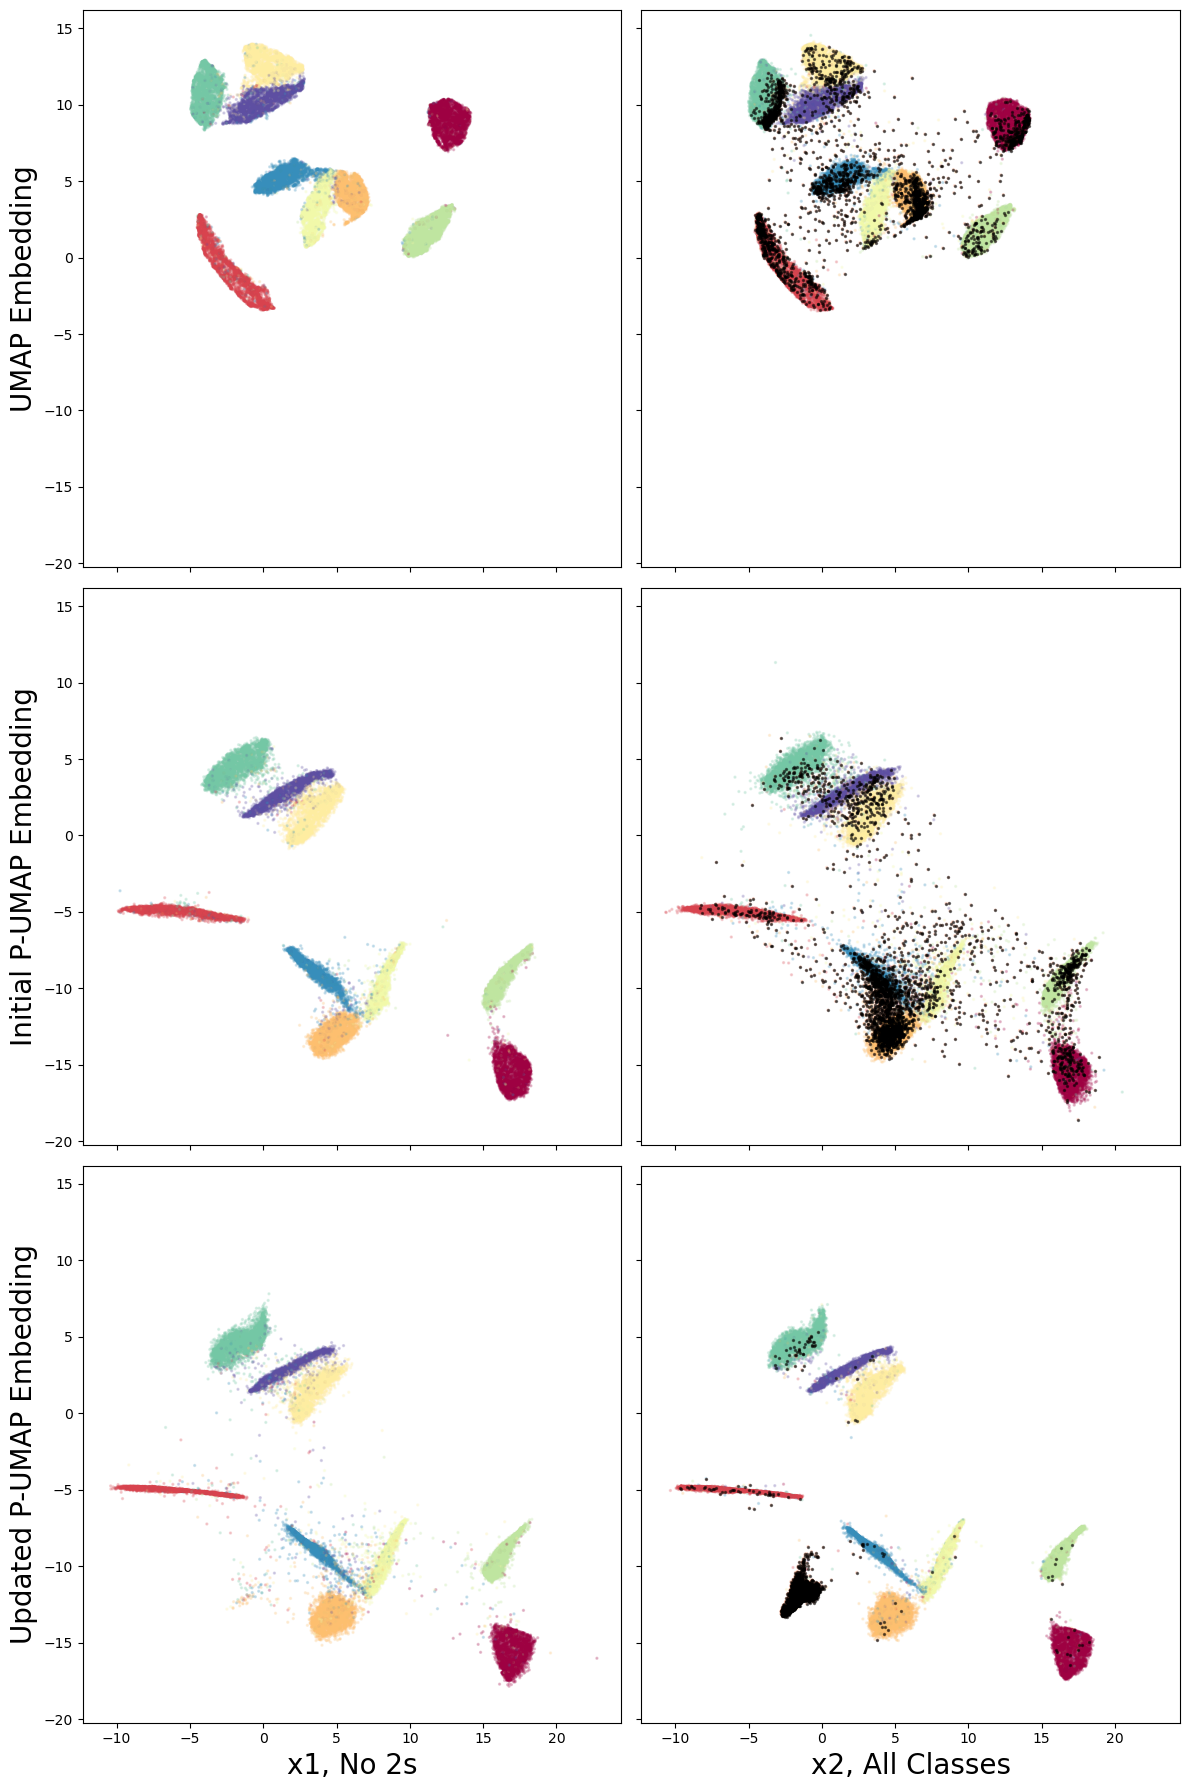

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(12, 18), sharex=True, sharey=True)

axs[0,0].scatter(
    emb_x1[:, 0], emb_x1[:, 1], c=y1, cmap='Spectral', s=2, alpha=0.2,
)
axs[0,0].set_ylabel('UMAP Embedding', fontsize=20)

axs[0,1].scatter(
    emb_x2[:, 0], emb_x2[:, 1], c=y2, cmap='Spectral', s=2, alpha=0.2,
)
axs[0,1].scatter(
    emb_x2[y2==N][:,0], emb_x2[y2==N][:,1], c='k', s=2, alpha=0.5,
)

axs[1,0].scatter(
    p_emb_x1[:, 0], p_emb_x1[:, 1], c=y1, cmap='Spectral', s=2, alpha=0.2,
)
axs[1,0].set_ylabel('Initial P-UMAP Embedding', fontsize=20)

axs[1,1].scatter(
    p_emb_x2[:, 0], p_emb_x2[:, 1], c=y2, cmap='Spectral', s=2, alpha=0.2,
)
axs[1,1].scatter(
    p_emb_x2[y2==N][:,0], p_emb_x2[y2==N][:,1], c='k', s=2, alpha=0.5
)

axs[2,0].scatter(
    p_emb2_x1[:, 0], p_emb2_x1[:, 1], c=y1, cmap='Spectral', s=2, alpha=0.2,
)
axs[2,0].set_ylabel('Updated P-UMAP Embedding', fontsize=20)
axs[2,0].set_xlabel(f'x1, No {N}s', fontsize=20)

axs[2,1].scatter(
    p_emb2_x2[:, 0], p_emb2_x2[:, 1], c=y2, cmap='Spectral', s=2, alpha=0.2,
)
axs[2,1].scatter(
    p_emb2_x2[y2==N][:,0], p_emb2_x2[y2==N][:,1], c='k', s=2, alpha=0.5,
)
axs[2,1].set_xlabel('x2, All Classes', fontsize=20)

plt.tight_layout()

It is worth double checking here that the landmark loss is not too constraining, we still would like a good UMAP structure.
To do so, we can interrogate the history of our embedder, which will retain the history through our re-training steps. Plotting it, we can identify the spike in loss where we introduce ``x2``, and can confirm that the resulting loss is comparable to the loss from our initial training on ``x1``. This tells us that the model is not having to compromise too much between the UMAP loss and the landmark loss. If this were not the case, it could potentially be improved by lowering the ``landmark_loss_weight`` attribute of our embedder object. There is a tradeoff to be made here between the consistency of the space and minimizing UMAP loss, but the key is we have smooth variation in the embedding space, which will make downstream tasks easier to adjust.

Text(0.5, 0, 'Epoch')

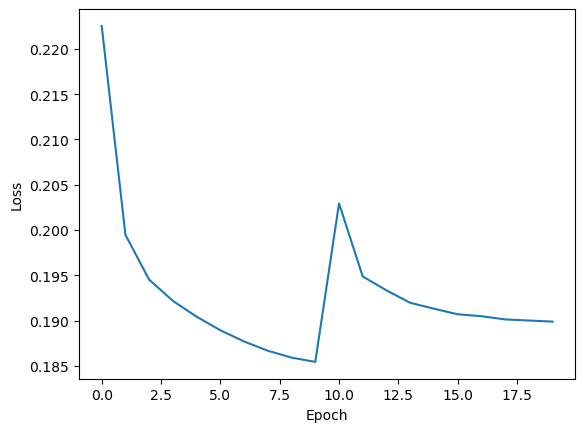

In [14]:
plt.plot(p_embedder._history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')

It is also worth noting that, due to the relatively straightforward nature of the MNIST dataset, we have achieved good results with just the default model and training regime of Parametric UMAP. Options for improving these results include:
- Using a CNN architecture instead of the default dense layers.
- Training for more epochs.
- Selecting the landmark points intelligently (e.g. points descriptive of the clusters).
- Trying different ``landmark_loss_fn`` options instead of the default euclidean distance, or different values for ``landmark_loss_weight``.